In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

In [22]:
df = pd.read_csv("/content/cleaned_diabetes_data_new.csv", low_memory=False)

Dropping unnecessary columns

In [7]:
df = df.drop(['encounter_id', 'patient_nbr'], axis=1, errors='ignore')

Converting False->0 and True->1

In [23]:
# bool -> int
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

# columns that were read as 'object' but contain boolean-like values
for col in df.select_dtypes(include=['object']).columns:
    unique_vals = df[col].dropna().unique()
    if set(unique_vals).issubset({'True', 'False'}):
        df[col] = df[col].map({'True': 1, 'False': 0})

df.head(3)

,encounter_id,patient_nbr,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,...,glipizide-metformin_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO,readmitted_target_0,readmitted_target_1
0,2278392,8222157,0,0,0,1,0,0,1,0,...,0,0,1,1,0,0,0,1,1,0
1,149190,55629189,0,0,0,1,0,0,1,0,...,0,1,0,0,1,0,1,0,1,0
2,64410,86047875,0,1,0,0,0,0,1,0,...,0,0,1,0,1,0,0,1,1,0


Redefining column for testing set

In [9]:
columns_to_drop = [
    'readmitted_>30',
    'readmitted_NO',
    'readmitted_target_0',
    'readmitted_target_1'
]

df = df.drop(columns=columns_to_drop, errors='ignore')

df = df.rename(columns={'readmitted_<30': 'readmitted_target'})

print(df['readmitted_target'].value_counts())

readmitted_target
0    90409
1    11357
Name: count, dtype: int64


Step 1 : Preparing data for modeling

In [10]:
# separating columns into target variables - X and y
y = df['readmitted_target']
X = df.drop('readmitted_target', axis=1)

Step 2 : Splitting the data into Training and Testing sets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# stratification
train_percentage = y_train.value_counts(normalize=True)[1] * 100
test_percentage = y_test.value_counts(normalize=True)[1] * 100

print("\n--- Stratification Check ---")
print(f"Percentage of '1's in training set: {train_percentage:.2f}%")
print(f"Percentage of '1's in testing set:  {test_percentage:.2f}%")


--- Stratification Check ---
Percentage of '1's in training set: 11.16%
Percentage of '1's in testing set:  11.16%


Step 3: Initialising the Model

In [12]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

print("Logistic Regression model has been initialized")


Logistic Regression model has been initialized


Step 4: Training the Model

In [13]:
model.fit(X_train, y_train)

print("\nTraining complete. The model has learned the patterns from the data.")



Training complete. The model has learned the patterns from the data.


Step 5 : Predictions by Model

In [14]:
y_pred = model.predict(X_test)

y_pred_probab = model.predict_proba(X_test)[:, 1]

print("\n--- Final Class Predictions ---")
print("'Yes' (1) or 'No' (0) predictions for each patient")
print("First 10 predictions:", y_pred[:10])

print("\n--- Prediction Probabilities ---")
print("Model's confidence scores (probabilities) of patient's readmission")
print("First 10 probabilities:", np.round(y_pred_probab[:10], 4))


--- Final Class Predictions ---
'Yes' (1) or 'No' (0) predictions for each patient
First 10 predictions: [1 0 1 1 1 0 0 0 1 1]

--- Prediction Probabilities ---
Model's confidence scores (probabilities) of patient's readmission
First 10 probabilities: [0.5063 0.4524 0.7379 0.6072 0.7251 0.4102 0.3377 0.2942 0.9004 0.6596]


Step 6 : Model Performance Evaluation


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.67      0.78     18083
           1       0.18      0.57      0.27      2271

    accuracy                           0.66     20354
   macro avg       0.55      0.62      0.53     20354
weighted avg       0.84      0.66      0.72     20354


--- Confusion Matrix ---


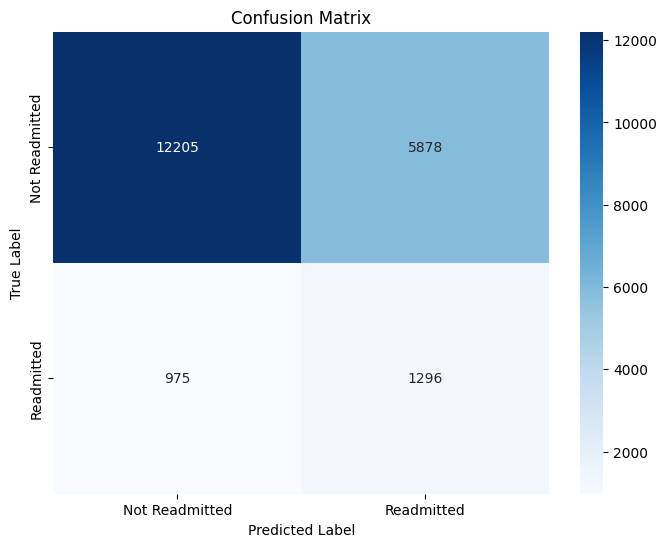


--- AUC-ROC Score ---
The AUC-ROC score for the model is: 0.6729


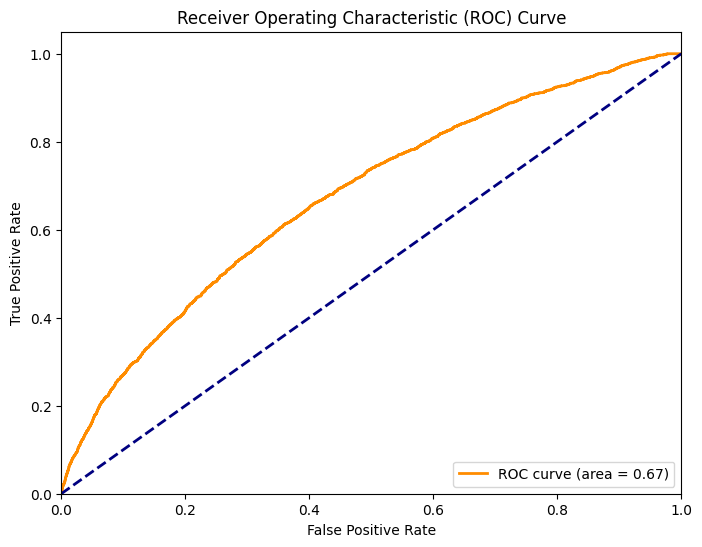

In [17]:
# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# AUC Score
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"\n--- AUC-ROC Score ---")
print(f"The AUC-ROC score for the model is: {auc_score:.4f}")


# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Model Feature Importance

--- Top 15 Factors INCREASING Likelihood of Readmission ---
                         Feature  Coefficient
52   discharge_disposition_id_28     1.735737
371          number_inpatient_15     1.728786
35    discharge_disposition_id_9     1.527649
38   discharge_disposition_id_12     1.471356
41   discharge_disposition_id_15     1.362478
47   discharge_disposition_id_22     1.298648
279           num_medications_72     1.224823
275           num_medications_67     1.173272
367          number_inpatient_11     1.087837
267           num_medications_59     1.080084
31    discharge_disposition_id_5     1.024387
188       num_lab_procedures_105     0.994602
387          number_diagnoses_11     0.912723
177        num_lab_procedures_94     0.837583
191       num_lab_procedures_108     0.821079

--- Top 15 Factors DECREASING Likelihood of Readmission ---
                         Feature  Coefficient
37   discharge_disposition_id_11    -5.153051
356           number_inpatient_0    -1.632627
25   

/tmp/ipython-input-18-4090855214.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_features_to_plot, palette='coolwarm')


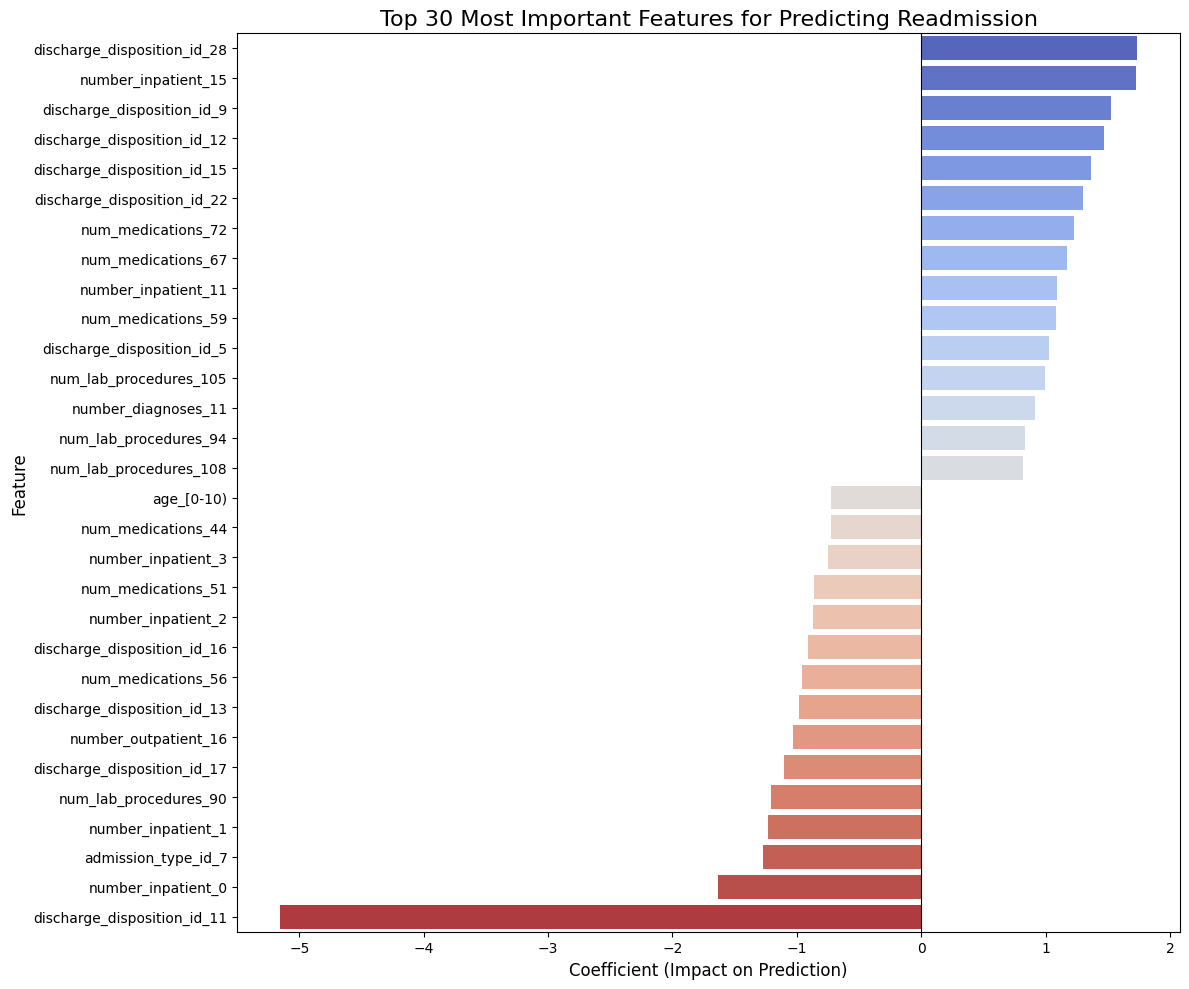

In [18]:
# creating dataframe for feauture and their coefficient
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})

# sorting the features - showing positive coefficients at the top
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# IMPORTANT FEATURES

top_positive_features = feature_importance.head(15)
print("--- Top 15 Factors INCREASING Likelihood of Readmission ---")
print(top_positive_features)


top_negative_features = feature_importance.tail(15).sort_values(by='Coefficient', ascending=True)
print("\n--- Top 15 Factors DECREASING Likelihood of Readmission ---")
print(top_negative_features)

# visualisation
top_features_to_plot = pd.concat([top_positive_features, top_negative_features.sort_values(by='Coefficient', ascending=False)])

plt.figure(figsize=(12, 10))
sns.barplot(x='Coefficient', y='Feature', data=top_features_to_plot, palette='coolwarm')
plt.title('Top 30 Most Important Features for Predicting Readmission', fontsize=16)
plt.xlabel('Coefficient (Impact on Prediction)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


Downloading Important Features dataset for Tableau Viz

In [25]:
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})

feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)
feature_importance_df = feature_importance_df.drop(columns='Abs_Coefficient')

feature_importance_filename = 'feature_importances.csv'
feature_importance_df.head(30).to_csv(feature_importance_filename, index=False)

files.download(feature_importance_filename)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading dataset after model predictions

In [28]:
results_df = X_test.copy()
results_df['Actual_Readmission'] = y_test
results_df['Predicted_Readmission'] = y_pred
results_df['Prediction_Probability'] = y_pred_proba

predictions_filename = 'patient_readmission_predictions.csv'
results_df.to_csv(predictions_filename, index=False)

files.download(predictions_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>